Relevant variables for model:
- summary
- description
- requestType
- causeOfIssue
- 

In [15]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import spacy
import re
import string
import sqlite3
from sqlalchemy import create_engine
import psycopg2

In [21]:
conn = psycopg2.connect(
    dbname="postgres", 
    user="root", 
    password="password1", 
    host="localhost", 
    port="5432"
)

# Define your SQL query
query = 'SELECT * FROM "Issue"'


# Execute the query and load the result into a DataFrame
df = pd.read_sql(query, conn)
print(df.columns)

Index(['Summary', 'Issue key', 'Issue id', 'Issue Type', 'Status',
       'Project key', 'Project name', 'Priority', 'Resolution', 'Assignee',
       'Reporter (Email)', 'Creator (Email)', 'Created', 'Updated',
       'Last Viewed', 'Resolved', 'Due date', 'Description', 'Partner Names',
       'Custom field (Cause of issue)', 'Custom field (Record/Transaction ID)',
       'Custom field (Region)', 'Custom field (Relevant Departments)',
       'Custom field (Relevant Departments).1',
       'Custom field (Request Category)', 'Custom field (Request Type)',
       'Custom field (Request language)', 'Custom field (Resolution Action)',
       'Satisfaction rating', 'Custom field (Satisfaction date)',
       'Custom field (Source)', 'Custom field (Time to first response)',
       'Custom field (Time to resolution)', 'Custom field (Work category)',
       'Status Category', 'Status Category Changed',
       'Custom field ([CHART] Date of First Response)', 'comments', 'category',
       'subca

/tmp/ipykernel_57770/906571591.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [17]:
print(df.head())


# Define the column mapping
column_mapping = {
    "Summary": "summary",
    "Issue key": "issueKey",
    "Issue id": "issueId",
    "Issue Type": "issueType",
    "Status": "status",
    "Project key": "projectKey",
    "Project name": "projectName",
    "Priority": "priority",
    "Resolution": "resolution",
    "Assignee": "assignee",
    "Reporter (Email)": "reporterEmail",
    "Creator (Email)": "creatorEmail",
    "Created": "created",
    "Updated": "updated",
    "Last Viewed": "lastViewed",
    "Resolved": "resolved",
    "Due date": "dueDate",
    "Description": "description",
    "Partner Names": "partnerNames",
    "Custom field (Cause of issue)": "causeOfIssue",
    "Custom field (Record/Transaction ID)": "recordTransactionId",
    "Custom field (Region)": "region",
    "Custom field (Relevant Departments)": "relevantDepartments",
    "Custom field (Relevant Departments).1": "relevantDepartments1",
    "Custom field (Request Category)": "requestCategory",
    "Custom field (Request Type)": "requestType",
    "Custom field (Request language)": "requestLanguage",
    "Custom field (Resolution Action)": "resolutionAction",
    "Satisfaction rating": "satisfactionRating",
    "Custom field (Satisfaction date)": "satisfactionDate",
    "Custom field (Source)": "source",
    "Custom field (Time to first response)": "timeToFirstResponse",
    "Custom field (Time to resolution)": "timeToResolution",
    "Custom field (Work category)": "workCategory",
    "Status Category": "statusCategory",
    "Status Category Changed": "statusCategoryChanged",
    "Custom field ([CHART] Date of First Response)": "dateOfFirstResponse",
    "comments": "comments"
}

# Rename the columns in the DataFrame
df.rename(columns=column_mapping, inplace=True)


                      Summary   Issue key  Issue id                Issue Type  \
0            SO-XXXXXX - TEST  PART1-5272     28196  [System] Service request   
1                     test 10  PART1-3843     28206  [System] Service request   
2               Test 5 - PART  PART1-6049     28107  [System] Service request   
3  Re: CAFB Pick Up TOMORROW   PART1-7176     65688  [System] Service request   
4                   addition   PART1-6512     55866  [System] Service request   

   Status Project key     Project name Priority Resolution Assignee  ...  \
0  Closed       PART1  Partner Support   Medium       Done       BM  ...   
1  Closed       PART1  Partner Support   Medium       Done       DH  ...   
2  Closed       PART1  Partner Support   Medium       Done       DH  ...   
3  Closed       PART1  Partner Support   Medium       Done       CH  ...   
4  Closed       PART1  Partner Support   Medium       Done       CH  ...   

  Satisfaction rating Custom field (Satisfaction date) C

In [22]:
for column in df.columns:
    print(f"{column}: {df[column].iloc[0]}")

Summary: SO-XXXXXX - TEST
Issue key: PART1-5272
Issue id: 28196
Issue Type: [System] Service request
Status: Closed
Project key: PART1
Project name: Partner Support
Priority: Medium
Resolution: Done
Assignee: BM
Reporter (Email): lioimmga.mgrcsuselo@a
Creator (Email): @orogaeimmgllsicas.um
Created: 2023-07-10 11:51:00
Updated: 2024-04-27 12:19:00
Last Viewed: 2025-02-26 03:05:00
Resolved: 2024-04-26 07:53:00
Due date: NaT
Description: 
Partner Names: 
Custom field (Cause of issue): 
Custom field (Record/Transaction ID): 
Custom field (Region): 
Custom field (Relevant Departments): 
Custom field (Relevant Departments).1: 
Custom field (Request Category): 
Custom field (Request Type): General Questions
Custom field (Request language): English
Custom field (Resolution Action): 
Satisfaction rating: 
Custom field (Satisfaction date): NaT
Custom field (Source): Portal
Custom field (Time to first response): 10500
Custom field (Time to resolution): 
Custom field (Work category): service-reque

In [4]:
# Data Preprocessing
def clean_text(text):
    if isinstance(text, str):
        # Remove non-alphabetic characters and lowercase the text
        text = re.sub(f"[{string.punctuation}]", "", text.lower())
        return text
    return ""
# Apply text cleaning to relevant columns
df['clean_summary'] = df['summary'].apply(clean_text)
df['clean_description'] = df['description'].apply(clean_text)
df['clean_comments'] = df['comments'].apply(lambda x: ' '.join([clean_text(comment) for comment in x.split(';')]))

# Handle missing values (drop rows with missing important columns)
df.dropna(subset=['summary', 'priority', 'issueType', 'status', 'comments'], inplace=True)

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

df['clean_summary'] = df['clean_summary'].apply(remove_stopwords)
df['clean_description'] = df['clean_description'].apply(remove_stopwords)
df['clean_comments'] = df['clean_comments'].apply(remove_stopwords)


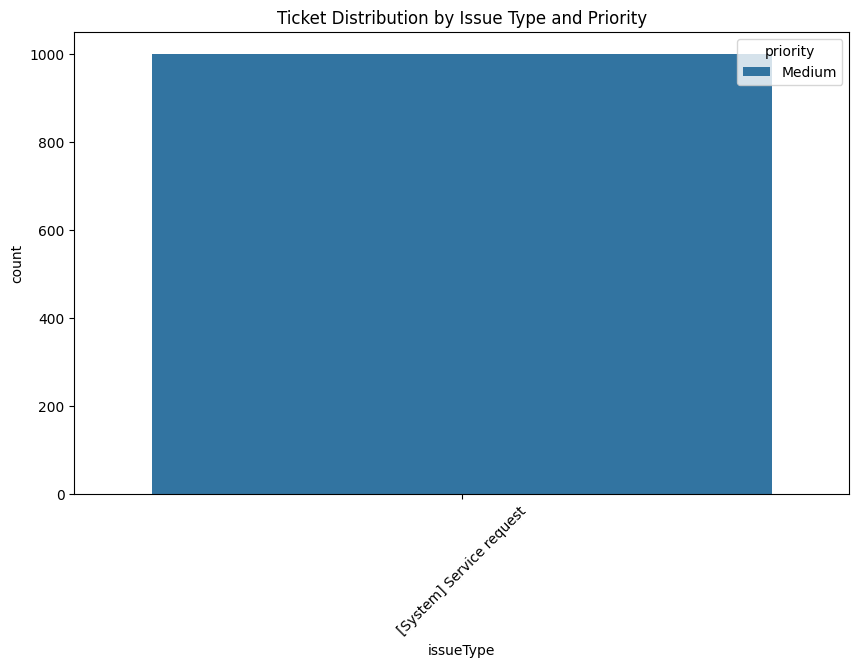

In [5]:
# Ticket distribution by issueType and priority
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='issueType', hue='priority')
plt.title("Ticket Distribution by Issue Type and Priority")
plt.xticks(rotation=45)
plt.show()

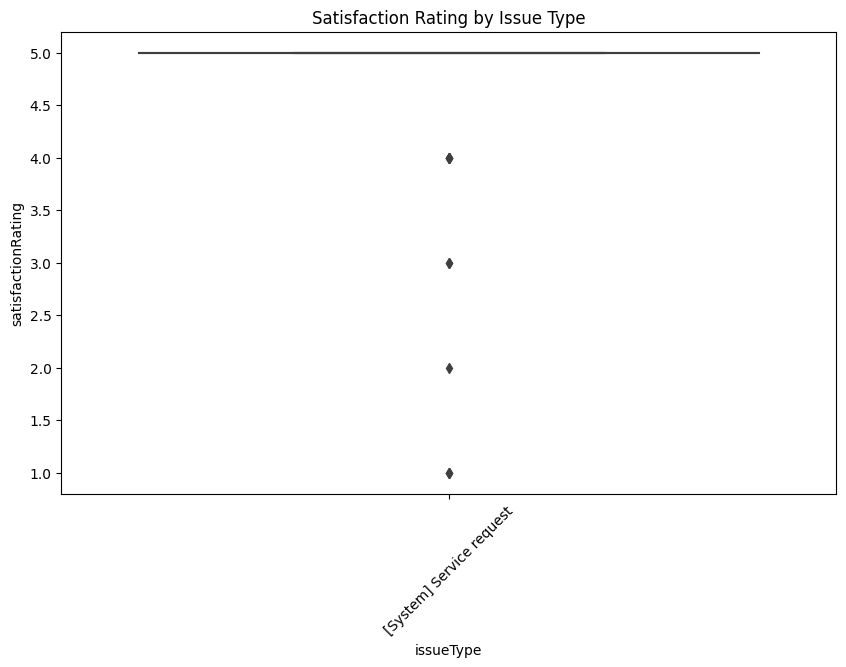

In [6]:
# Satisfaction rating vs issue type
df['satisfactionRating'] = pd.to_numeric(df['satisfactionRating'], errors='coerce')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='issueType', y='satisfactionRating')
plt.title("Satisfaction Rating by Issue Type")
plt.xticks(rotation=45)
plt.show()

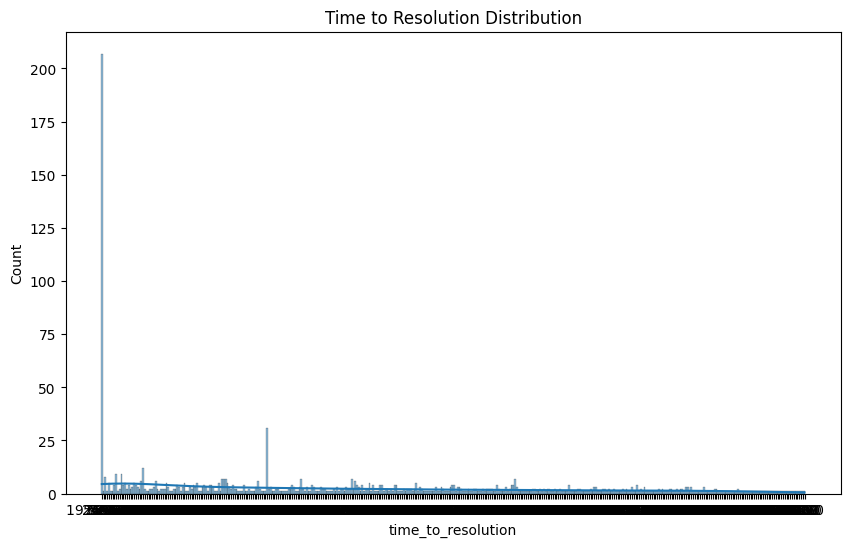

In [7]:
# Time to resolution analysis
df['time_to_resolution'] = df['timeToResolution'].apply(lambda x: x if pd.notnull(x) else 0)
plt.figure(figsize=(10, 6))
sns.histplot(df['time_to_resolution'], kde=True)
plt.title("Time to Resolution Distribution")
plt.show()

In [8]:
# Sentiment Analysis on Comments using TextBlob
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity

df['comment_sentiment'] = df['clean_comments'].apply(get_sentiment)

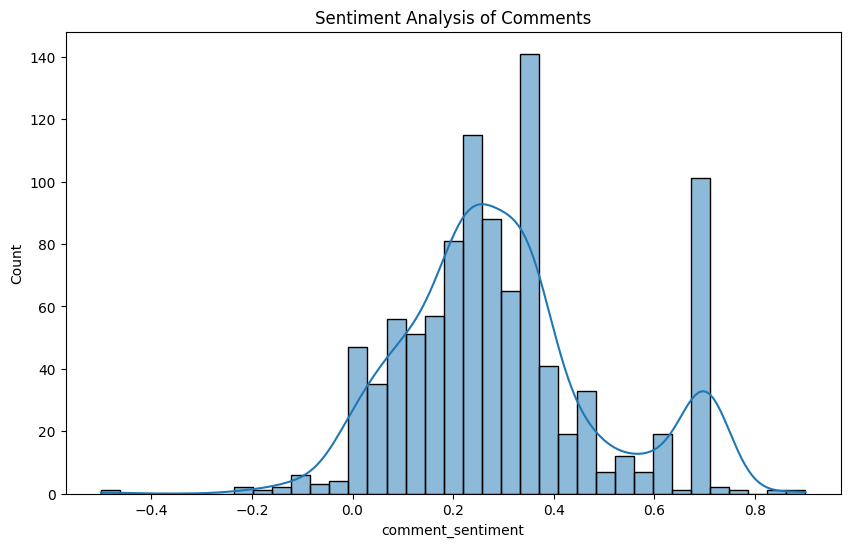

In [9]:
# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['comment_sentiment'], kde=True)
plt.title("Sentiment Analysis of Comments")
plt.show()

In [10]:
# Topic Modeling using LDA
# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_comments'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=5, random_state=42)

In [11]:
# Display topics
for index, topic in enumerate(lda.components_):
    print(f"Topic {index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11 - 1:-1]])

Topic 0:
['hours', 'thank', 'business', 'customer', 'day', 'food', 'area', 'relations', 'capital', 'pm', 'contacting']
Topic 1:
['date', 'field', 'new', 'jira', 'ticket', 'set', 'updated', 'used', 'automation', 'prior', 'todays']
Topic 2:
['thank', 'good', 'order', 'customer', 'morning', '61536ea272f6970069fc1dbd', 'afternoon', 'contacting', 'support', '712020b15fa988bc6049b4aa6fe30b7a3629c1', 'team']
Topic 3:
['type', 'text', 'attrs', 'content', 'marks', 'color', 'textcolor', 'paragraph', '172b4d', 'link', 'href']
Topic 4:
['reply', 'thank', 'customer', 'request', '557058f58131cbb67d43c7b30d6b58d40bd077', 'capital', 'food', 'area', 'possible', 'soon', 'update']


In [12]:
# Train a Classifier to predict if a ticket can be handled by the bot or needs escalation
# Use 'summary' and 'description' as features
X = df[['clean_summary', 'clean_description']]
y = df['priority'].apply(lambda x: 1 if x == 'High' else 0)  # High priority -> 1 (escalation), Low/Medium -> 0 (bot can handle)

# Vectorize text data
X_text = X.apply(lambda row: row['clean_summary'] + ' ' + row['clean_description'], axis=1)
X_text_vec = vectorizer.fit_transform(X_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_text_vec, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [14]:
# Bot Context Creation (using a sample query)
def generate_ticket_context(ticket_id):
    ticket = df[df['issueKey'] == ticket_id]
    if ticket.empty:
        return "Ticket not found."
    
    context = {
        'summary': ticket['summary'].values[0],
        'priority': ticket['priority'].values[0],
        'status': ticket['status'].values[0],
        'description': ticket['description'].values[0],
        'comments': ticket['comments'].values[0]
    }
    
    return context

# Example usage:
ticket_id = 'PART1-5272'
print(generate_ticket_context(ticket_id))

{'summary': 'SO-XXXXXX - TEST', 'priority': 'Medium', 'status': 'Closed', 'description': '', 'comments': '{"07/10/2023 01:07;5fb17b020dd553006f17ff0a;Hi Darb,\n\nWe will look into this.","07/10/2023 01:07;5fb17b020dd553006f17ff0a;I think this needs to go to IT","07/10/2023 01:10;5fb29c170dd553006f224f06;h6. ðŸ\x8f³ï¸\x8f Message originally posted in [IT-4689|https://capitalareafoodbank.atlassian.net/browse/IT-4689] on 10/Jul/2023 01:09 PM\n\nOK I will look","07/10/2023 01:10;5fb29c170dd553006f224f06;h6. ðŸ\x8f³ï¸\x8f Message originally posted in [IT-4689|https://capitalareafoodbank.atlassian.net/browse/IT-4689] on 10/Jul/2023 01:10 PM\n\nDarb,\n\nCan you tell us more","07/10/2023 01:11;qm:65d20c5a-0c84-458e-8ce1-adb90d07460f:19f932b4-b42f-4723-a915-05c76f1f5806;This is what is happeningâ€¦","07/10/2023 01:21;5fb29c170dd553006f224f06;{quote}*[IT-4689]* \\"Ticket From - Partner Support - SO-XXXXXX - TEST\\" has been changed to a status of *Completed*\n----\nPlease check this issue for mo